<a href="https://colab.research.google.com/github/pankaj90382/TSAI/blob/master/S5/EVA4_Session_5_Approach1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [0]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.convblock1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3, 3), padding=1, bias=False) 
        self.convblock2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=1, bias=False)
        self.convblock3 = nn.Conv2d(in_channels=16, out_channels=8, kernel_size=(1, 1), padding=0, bias=False)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.convblock4 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=1, bias=False)
        self.convblock5 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), padding=1, bias=False)
        self.convblock6 = nn.Conv2d(in_channels=32, out_channels=8, kernel_size=(1, 1), padding=0, bias=False)
        self.convblock7 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=1, bias=False)
        self.convblock8 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=1, bias=False)
        self.gap = nn.Sequential(nn.AvgPool2d(kernel_size=7)) # output_size = 1
        self.convblock9 = nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False)
        #self.conv6 = nn.Conv2d(32, 32, 3)
        #self.conv7 = nn.Conv2d(32, 10, 3)

    def forward(self, x):
        x = self.convblock1(x) #input - 28; Output - 28; RF - 3; output channels - 8
        x = self.convblock2(x) #input - 28; Output - 28; RF - 5; output channels - 16
        x = self.convblock3(x) #input - 28; Output - 28; RF - 5; output channels - 8
        x = self.pool1(x) #input - 28; Output - 14; RF - 6; output channels - 8
        x = self.convblock4(x)#input - 14; Output - 14; RF - 10; output channels - 16
        x = self.convblock5(x)#input - 14; Output - 14; RF - 14; output channels - 32
        x = self.convblock6(x)#input - 14; Output - 14; RF - 14; output channels - 8
        x = self.pool1(x) #input - 14; Output - 7; RF - 16; output channels - 8
        x = self.convblock7(x) #input - 7; Output - 7; RF - 24; output channels - 16
        x = self.convblock8(x)  #input - 7; Output - 7; RF - 32; output channels - 16
        x = self.gap(x)        
        x = self.convblock9(x)
        x = x.view(-1, 10)
        return F.log_softmax(x)

In [0]:
#!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 28, 28]              72
            Conv2d-2           [-1, 16, 28, 28]           1,152
            Conv2d-3            [-1, 8, 28, 28]             128
         MaxPool2d-4            [-1, 8, 14, 14]               0
            Conv2d-5           [-1, 16, 14, 14]           1,152
            Conv2d-6           [-1, 32, 14, 14]           4,608
            Conv2d-7            [-1, 8, 14, 14]             256
         MaxPool2d-8              [-1, 8, 7, 7]               0
            Conv2d-9             [-1, 16, 7, 7]           1,152
           Conv2d-10             [-1, 16, 7, 7]           2,304
        AvgPool2d-11             [-1, 16, 1, 1]               0
           Conv2d-12             [-1, 10, 1, 1]             160
Total params: 10,984
Trainable params: 10,984
Non-trainable params: 0
----------------------------

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


In [0]:
torch.manual_seed(1)
batch_size = 128

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                    transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)


In [0]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
    model.train()
    pbar = tqdm(train_loader)
    correct = 0
    processed = 0
    for batch_idx, (data, target) in enumerate(pbar):
        # get samples
        data, target = data.to(device), target.to(device)
        # Init
        optimizer.zero_grad()
        # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
        # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.
        
        # Predict
        y_pred = model(data)
        
        # Calculate loss
        loss = F.nll_loss(y_pred, target)
        train_losses.append(loss)

        # Backpropagation
        loss.backward()
        optimizer.step()
        
        # Update pbar-tqdm
        pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()
        processed += len(data)

        pbar.set_description(desc= f'loss={loss.item()} batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
        train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

In [0]:
from torch.optim.lr_scheduler import StepLR

model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
#scheduler = StepLR(optimizer, step_size=6, gamma=0.1)


EPOCHS = 20
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    # scheduler.step()
    test(model, device, test_loader)

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
loss=1.9381345510482788 batch_id=468 Accuracy=13.25: 100%|██████████| 469/469 [00:10<00:00, 43.02it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 2.0033, Accuracy: 2333/10000 (23.33%)

EPOCH: 1


loss=0.4410935342311859 batch_id=468 Accuracy=69.54: 100%|██████████| 469/469 [00:11<00:00, 39.24it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.3661, Accuracy: 8857/10000 (88.57%)

EPOCH: 2


loss=0.36254799365997314 batch_id=468 Accuracy=89.55: 100%|██████████| 469/469 [00:11<00:00, 42.35it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2417, Accuracy: 9282/10000 (92.82%)

EPOCH: 3


loss=0.14053656160831451 batch_id=468 Accuracy=92.77: 100%|██████████| 469/469 [00:11<00:00, 42.13it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2015, Accuracy: 9344/10000 (93.44%)

EPOCH: 4


loss=0.32630208134651184 batch_id=468 Accuracy=94.10: 100%|██████████| 469/469 [00:11<00:00, 42.22it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1789, Accuracy: 9471/10000 (94.71%)

EPOCH: 5


loss=0.15685616433620453 batch_id=468 Accuracy=94.34: 100%|██████████| 469/469 [00:11<00:00, 42.14it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1443, Accuracy: 9551/10000 (95.51%)

EPOCH: 6


loss=0.3067929744720459 batch_id=468 Accuracy=94.88: 100%|██████████| 469/469 [00:11<00:00, 41.09it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1567, Accuracy: 9515/10000 (95.15%)

EPOCH: 7


loss=0.21599489450454712 batch_id=468 Accuracy=95.49: 100%|██████████| 469/469 [00:11<00:00, 42.55it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1439, Accuracy: 9519/10000 (95.19%)

EPOCH: 8


loss=0.10938198119401932 batch_id=468 Accuracy=95.69: 100%|██████████| 469/469 [00:10<00:00, 43.22it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1156, Accuracy: 9652/10000 (96.52%)

EPOCH: 9


loss=0.09360656142234802 batch_id=468 Accuracy=96.01: 100%|██████████| 469/469 [00:10<00:00, 45.32it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1156, Accuracy: 9632/10000 (96.32%)

EPOCH: 10


loss=0.08516018837690353 batch_id=468 Accuracy=96.15: 100%|██████████| 469/469 [00:10<00:00, 43.83it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1179, Accuracy: 9638/10000 (96.38%)

EPOCH: 11


loss=0.10421580821275711 batch_id=468 Accuracy=96.33: 100%|██████████| 469/469 [00:10<00:00, 44.41it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1257, Accuracy: 9636/10000 (96.36%)

EPOCH: 12


loss=0.13856226205825806 batch_id=468 Accuracy=96.42: 100%|██████████| 469/469 [00:10<00:00, 44.78it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1059, Accuracy: 9644/10000 (96.44%)

EPOCH: 13


loss=0.10172933340072632 batch_id=468 Accuracy=96.55: 100%|██████████| 469/469 [00:10<00:00, 43.58it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1062, Accuracy: 9674/10000 (96.74%)

EPOCH: 14


loss=0.08058648556470871 batch_id=468 Accuracy=96.67: 100%|██████████| 469/469 [00:10<00:00, 43.14it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0906, Accuracy: 9719/10000 (97.19%)

EPOCH: 15


loss=0.1398237943649292 batch_id=468 Accuracy=96.92: 100%|██████████| 469/469 [00:11<00:00, 40.41it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0816, Accuracy: 9730/10000 (97.30%)

EPOCH: 16


loss=0.09191163629293442 batch_id=468 Accuracy=96.94: 100%|██████████| 469/469 [00:10<00:00, 43.41it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0918, Accuracy: 9698/10000 (96.98%)

EPOCH: 17


loss=0.04517850652337074 batch_id=468 Accuracy=97.02: 100%|██████████| 469/469 [00:10<00:00, 43.25it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0785, Accuracy: 9747/10000 (97.47%)

EPOCH: 18


loss=0.0790380984544754 batch_id=468 Accuracy=97.00: 100%|██████████| 469/469 [00:11<00:00, 41.30it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0796, Accuracy: 9725/10000 (97.25%)

EPOCH: 19


loss=0.06347308307886124 batch_id=468 Accuracy=97.12: 100%|██████████| 469/469 [00:11<00:00, 41.06it/s]



Test set: Average loss: 0.0834, Accuracy: 9740/10000 (97.40%)



# Let's Train and test our model

This time let's add a scheduler for out LR. 

Text(0.5, 1.0, 'Test Accuracy')

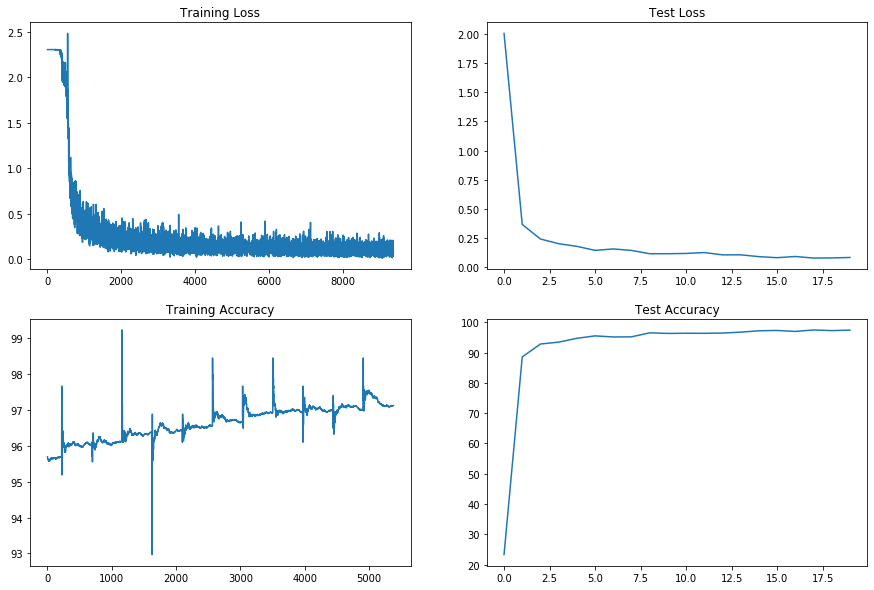

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc[4000:])
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

Approach 1 

No Image Augmentation, No LR Decay, No dropout, No batch normalization. 
Limit my parameters in 11k. I want to test my accuracy and need to know what my model is capable of doing. If it overfits, then i reduce my parameter further otherwise if it is underfit, then try to increase the parameters.

Used parameters -10,984<br>
Human's based performance -99.7<br>
Maximum Train Accuracy Achieved -97.77<br>
Maximum Test Accuracy Achieved - 97.89<br>
Maximum - Epoch -20<br>

Observations - The accuracy can be increased further. The accuracy has incremental trend. The model is underfit by looking at the human level accuracy. So i will try to increase the parameters. In the Initial training phase of the model, the loss is not decreasing as much.
